# Boca Juniors v. Belgrano @ Mon 15 May
Say I'd like to earn money waging on the result of this match, how should I go about it? I want to win more money that what I bet, so the _expected value_ of every bet should be positive.

Given the house odds, and a given estimate of each outcome's probability, we can calculate the EV of the available bets : Boca wins (`1`), Belgrano wins (`2`) or draw (`X`).

Let's start simple: for every team $T$, there's a fixed goal rate $\lambda_T$, so that the number of goals that T scores in any given match is independently and identically distributed as $Poisson(\lambda_T)$.

There's probably a closed form solution for such a simple model but simulations suffice to estimate each outcome's probabilities. So, if the match ends $X-Y$, where $X\sim Poisson(\lambda_1)$ and $Y\sim Poisson(\lambda_2)$, we have
$$
P(1\ wins) = P(X > Y) \\
P(2\ wins) = P(X < Y) \\
P(draw) = P(X = Y) \\
$$

In [46]:
import numpy as np
import pandas as pd


def simulate(lambda_A, lambda_B, K):
    # Simulate K matches between teams A and B
    results = []
    for i in range(K):
        # Simulate the number of goals for each team using Poisson distributions
        goals_1 = np.random.poisson(lambda_A)
        goals_2 = np.random.poisson(lambda_B)

        goal_spread = goals_1 - goals_2

        # Determine the winner of the match
        if goal_spread > 0:
            winner = "1"
        elif goal_spread < 0:
            winner = "2"
        else:
            winner = "X"

        # Store the results in a dictionary
        result = {
            "Match": i + 1,
            "Team 1 Goals": goals_1,
            "Team 2 Goals": goals_2,
            "Goal Spread": goal_spread,
            "Winner": winner,
        }
        results.append(result)

    return pd.DataFrame(results)

In [47]:
lambda_A = 1.5
lambda_B = 1.2
K = 100000

df = simulate(lambda_A, lambda_B, K)

In [48]:
df.head()

,Match,Team 1 Goals,Team 2 Goals,Goal Spread,Winner
0,1,1,2,-1,2
1,2,1,1,0,X
2,3,1,0,1,1
3,4,3,0,3,1
4,5,2,1,1,1


<Axes: >

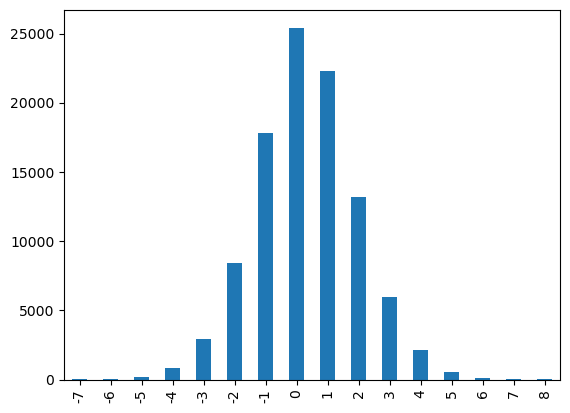

In [52]:
df["Goal Spread"].value_counts().sort_index().plot(kind="bar")

In [53]:
(df.groupby("Winner").size() / K)

Winner
1    0.44238
2    0.30320
X    0.25442
dtype: float64

In [54]:
import requests
from bs4 import BeautifulSoup

# Define the URL to scrape
url = 'https://www.bet365.bet.ar/?_h=3LwNG5H5dnUh2GAZlKipZQ%3D%3D#/AC/B1/C1/D1002/E84855132/G40/'

# Send a GET request to the URL and get the HTML content
response = requests.get(url)
html_content = response.content

# Parse the HTML content using BeautifulSoup
soup = BeautifulSoup(html_content, 'html.parser')

# Find all the <p> tags on the page and extract their text content
p_tags = soup.find_all('p')
p_texts = [p.get_text() for p in p_tags]

# Print the extracted text content
print(*p_texts, sep="\n")

You do not have access to www.bet365.bet.ar.
The site owner may have set restrictions that prevent you from accessing the site.
Error details
Provide the site owner this information.
I got an error when visiting www.bet365.bet.ar/?_h=3LwNG5H5dnUh2GAZlKipZQ%3D%3D.
Error code: 1020
Ray ID: 7c76706e7d0aab38
Country: AR
Data center: eze03
IP: 186.18.0.116
Timestamp: 2023-05-14 22:04:50 UTC
Click to copy

               Performance & security by Cloudflare 



A Manopla!

![Alt text](boca-belgrano.png)

In [55]:
# From Boca's perspective
house_odds = pd.Series([1.75, 3.3, 5.75], ["1", "X", "2"])
house_odds

1    1.75
X    3.30
2    5.75
dtype: float64

In [56]:
import requests
from bs4 import BeautifulSoup

# Define the URL to scrape
url = 'https://www.promiedos.com.ar/primera'

# Send a GET request to the URL and get the HTML content
response = requests.get(url)
html_content = response.content

# Parse the HTML content using BeautifulSoup
soup = BeautifulSoup(html_content, 'html.parser')
historico = soup.find("table")
import pandas as pd

# Assuming you have a Beautifulsoup object called "soup" and a table element called "table"
# You can extract the table rows and columns using the find_all method
rows = historico.find_all('tr')
columns = [v.text.replace('\n', '') for v in rows[0].find_all('th')]

# Extract values from each row
values = []
for i in range(1, len(rows)):
    tds = rows[i].find_all('td')
    values.append([td.text.replace('\n', '') for td in tds])
df = pd.DataFrame(values, columns=columns)

df = df.set_index("Equipo").astype(int)

In [57]:
df.head()

,#,Pts,PJ,PG,PE,PP,GF,GC,DIF
Equipo,,,,,,,,,
River Plate,1,37,15,12,1,2,26,6,20
San Lorenzo,2,32,16,9,5,2,17,6,11
Def y Justicia,3,29,16,8,5,3,21,9,12
Estudiantes (LP),4,28,16,8,4,4,19,14,5
Belgrano,5,28,16,8,4,4,14,11,3


In [58]:
df["GPP"] = df["GF"] / df["PJ"]

In [59]:
teams = home, away = ["Boca Juniors", "Belgrano"]

In [60]:
df.loc[teams]

,#,Pts,PJ,PG,PE,PP,GF,GC,DIF,GPP
Equipo,,,,,,,,,,
Boca Juniors,15,19,16,5,4,7,18,16,2,1.125
Belgrano,5,28,16,8,4,4,14,11,3,0.875


In [61]:
sim = simulate(*df.loc[teams, "GPP"], K)
p_hat = sim.groupby("Winner").size() / K

In [62]:
neutral_odds = 1 / p_hat
odds_df = pd.DataFrame.from_records([house_odds, neutral_odds], index=["House", "Neutral"])

In [63]:
odds_df.round(2)

,1,X,2
House,1.75,3.3,5.75
Neutral,2.41,3.3,3.55


In [64]:
(1 / house_odds).sum()

1.0483719179371351

In [65]:
np.sum(1 / house_odds)

1.0483719179371351

Aja! Casa mala.

In [66]:
house_probs = 1 / house_odds


In [67]:
pd.DataFrame.from_records([p_hat, 1 / house_odds], index=["Sim", "House"]).round(3)

,1,2,X
Sim,0.415,0.282,0.303
House,0.571,0.174,0.303


In [68]:
ev = p_hat * (house_odds - 1) + (1 - p_hat) * -1
ev

1   -0.273838
2    0.620982
X    0.000362
dtype: float64

### Conclusion
Belgrano is the only +EV bet.

###TODO
- Learn $\lambda_T$'s. Fit a Poisson GLM using past match outcomes for each team in a league.
  - Consider interaction terms for specific match-ups.
- Different approach: consider the match result $(X, Y)$ as a bivariate response directly?
  - Consider dummies for referee selection or pairs (referee, team) to capture the "Boca effect."
- Bet sizing. Something with Kelly criterion.